## Proyecto Final - Clasificador de hongos comestibles y venenosos por medio de CNN

<p>Click para acceder el conjunto de datos <a href="https://www.kaggle.com/datasets/marcosvolpato/edible-and-poisonous-fungi">Edible and Poisonous Fungi</a>.</p>

<style>
    .imagen-ajustada {
        width: 900px;
        height: 280px;
        border-radius: 20px;
    }
</style>

<img src="hongos.jpg" alt="Una imagen" class="imagen-ajustada">

El propósito del proyecto consiste en implementar un sistema de clasificación de imágenes orientado a determinar la comestibilidad o toxicidad de hongos, empleando redes neuronales con el fin de mejorar la precisión en la categorización. Además, se han empleado otros modelos con el objetivo de evaluar la eficacia del clasificador propuesto. El conjunto de imágenes utilizado fue adquirido a través de Kaggle, exhibiendo una diversidad considerable en cuanto a la morfología de las imágenes, lo que incluye representaciones gráficas como dibujos.

## Librerías Utilizadas

Se pueden apreciar las librer&iacute;as utilizadas a lo largo del proyecto.

In [1]:
# Importamos las liberias necesarias
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2
from tensorflow.keras import datasets, layers, models
from numpy.random import randint
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from numpy import mean
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
# Librerias necesarias para el aumento de datos
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from sklearn.model_selection import StratifiedShuffleSplit
import visualkeras

## Análisis Exploratorio

La fase inicial para familiarizarnos con nuestro conjunto de datos implica la exploración. En este contexto, se realizó un recuento de las imágenes correspondientes tanto a hongos comestibles como a hongos venenosos. Los resultados revelaron que hay una mayor cantidad de imágenes asociadas a hongos venenosos en comparación con las imágenes de hongos comestibles.

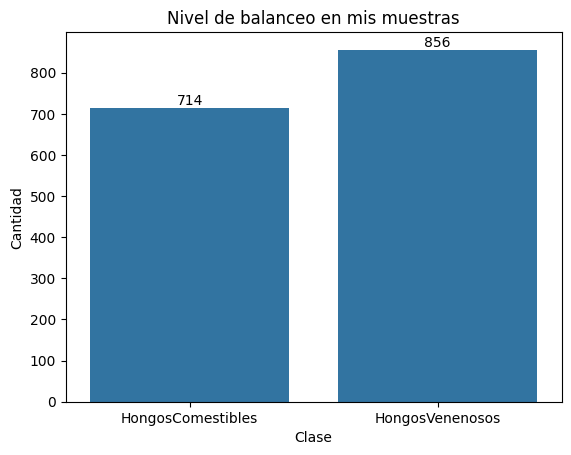

In [2]:
path = os.getcwd() + "/Dataset_Hongos"
hongos_comestibles = None
hongos_venenosos = None
for category in os.listdir(path=path):
    category_dir = os.path.join(path, category)
    if category == 'HongosComestibles':
        hongos_comestibles = len(os.listdir(category_dir))
    else: hongos_venenosos = len(os.listdir(category_dir))
data = {'Clase':['HongosComestibles', 'HongosVenenosos'], 'Cantidad': [hongos_comestibles, hongos_venenosos]}
df = pd.DataFrame(data)
sns.barplot(df, x='Clase', y="Cantidad")
for index, value in enumerate(df['Cantidad']):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.title('Nivel de balanceo en mis muestras')
plt.show()

Además, es importante fijarnos en la variedad de las imágenes en nuestro grupo de datos. Al mirar las gráficas, notamos que todas las fotos son bastante diferentes entre ellas. Esto destaca lo diverso que es el conjunto, mostrando lo importante que es considerar todas esas diferencias al trabajar con modelos y evaluar su rendimiento.

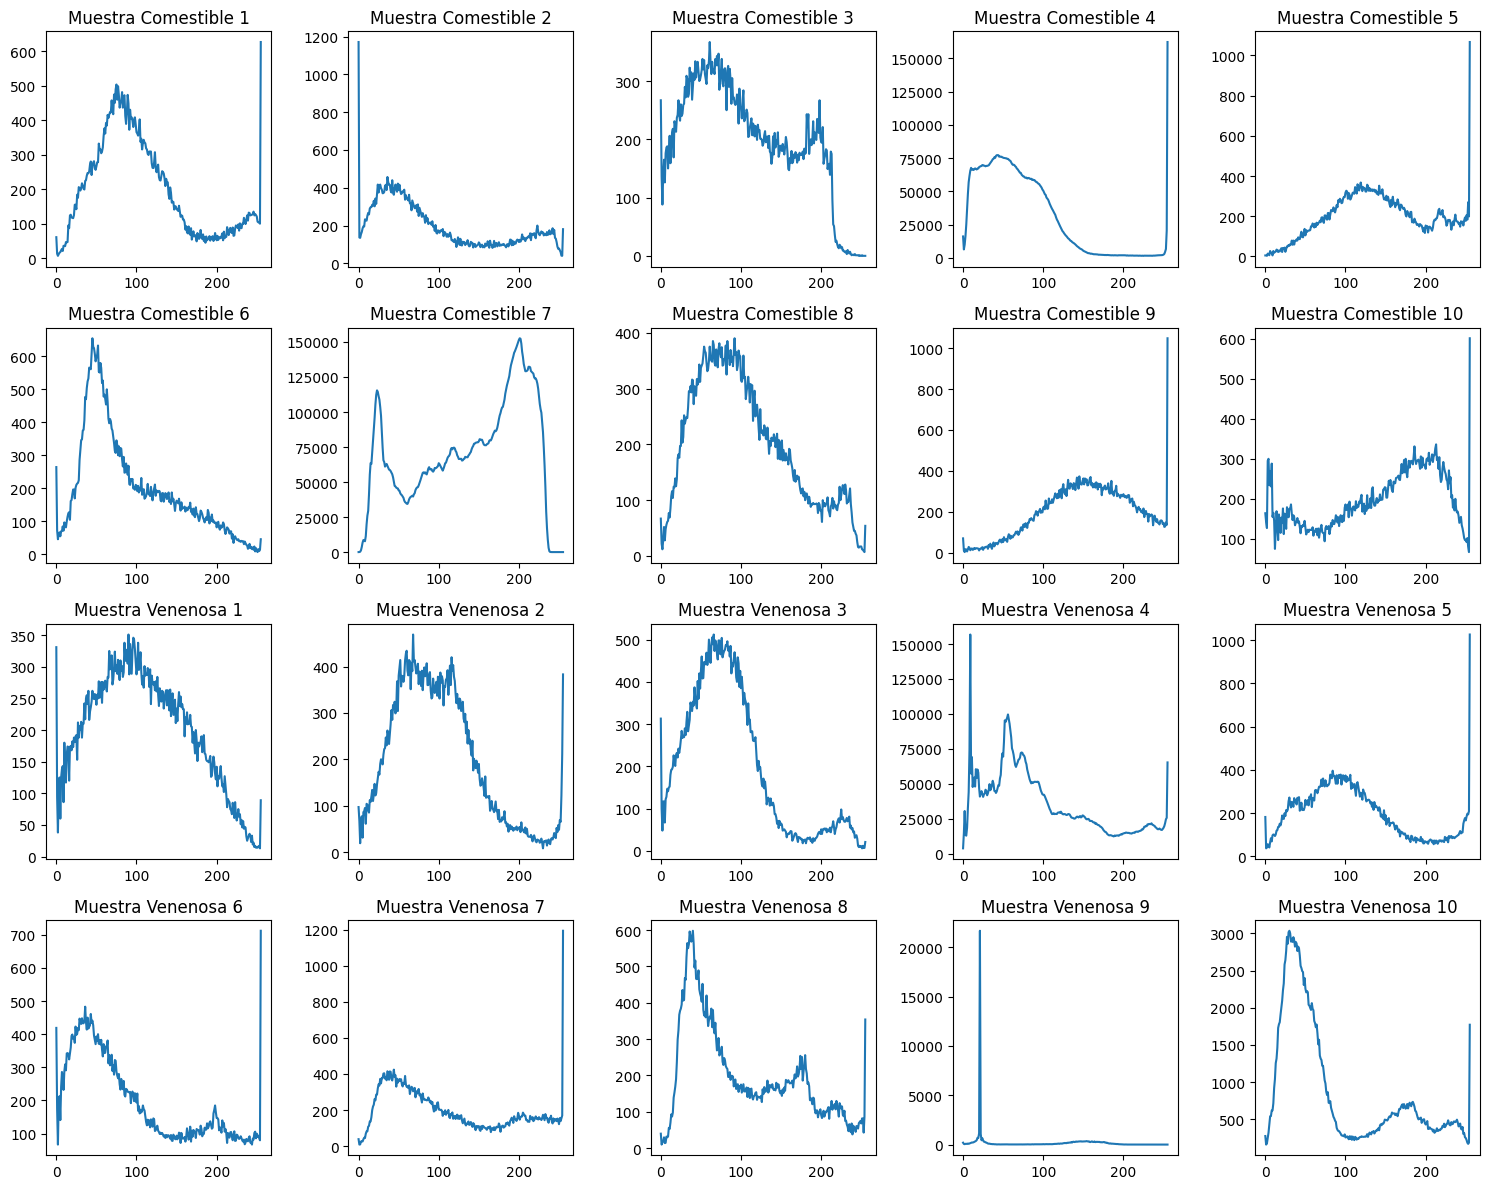

In [3]:
path = os.getcwd() + "/Dataset_Hongos"
comestibles_folder = path +'/HongosComestibles'
venenosos_folder = path +'/HongosVenenosos'
comestibles_files = os.listdir(comestibles_folder)
venenosos_files = os.listdir(venenosos_folder)
muestras_comestibles = np.random.choice(comestibles_files, 10, replace=False)
muestras_venenosas = np.random.choice(venenosos_files, 10, replace=False)
fig, ax = plt.subplots(4, 5, figsize=(15, 12))
def plot_histogram(ax, image, title):
    RGB_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hist = cv2.calcHist([RGB_image], [0], None, [256], [0, 256])
    ax.plot(hist)
    ax.set_title(title)
for i, muestra_comestible in enumerate(muestras_comestibles):
    row = i // 5
    col = i % 5
    image_path = os.path.join(comestibles_folder, muestra_comestible)
    image = cv2.imread(image_path)
    plot_histogram(ax[row, col], image, f'Muestra Comestible {i + 1}')
for i, muestra_venenosa in enumerate(muestras_venenosas):
    row = (i + len(muestras_comestibles)) // 5
    col = (i + len(muestras_comestibles)) % 5
    image_path = os.path.join(venenosos_folder, muestra_venenosa)
    image = cv2.imread(image_path)
    plot_histogram(ax[row, col], image, f'Muestra Venenosa {i + 1}')
plt.tight_layout()
plt.show()


Con el propósito de mitigar posibles complicaciones durante el entrenamiento de la red neuronal, se procederá a equilibrar las muestras, asegurando que ambas categorías cuenten con un total de 700 imágenes. Para llevar a cabo este proceso, se han cargado las imágenes designadas para el conjunto de prueba, y se ha realizado la conversión de dichas imágenes a un formato compatible con TensorFlow.

In [4]:
# Se define la ruta a la carpeta que contiene las imágenes que se usaran para prueba
data_test = os.getcwd() + "/Dataset_Hongos"

max_muestras = 700
# Se cargan las imágenes que se usaran para prueba 
images = []
labels = []
for category in os.listdir(data_test):
  category_dir = os.path.join(data_test, category)
  for image_file, i in zip(os.listdir(category_dir), range(max_muestras)):
    image_test = cv2.imread(os.path.join(category_dir, image_file))
    image_test = cv2.resize(image_test, (256, 256))  # Redimensionamos las imágenes a 256x256
    images.append(image_test)
    labels.append(category)
cv2.destroyAllWindows()
# Convertimos las imágenes a un formato compatible con TensorFlow
images = np.array(images)
images = images.astype(np.float32)

Con el objetivo de validar el equilibrio alcanzado en nuestras imágenes, se procede a imprimir el número de muestras por clase en un gráfico. La representación gráfica resultante se presenta a continuación para permitir una visualización clara de las clases correspondientes.

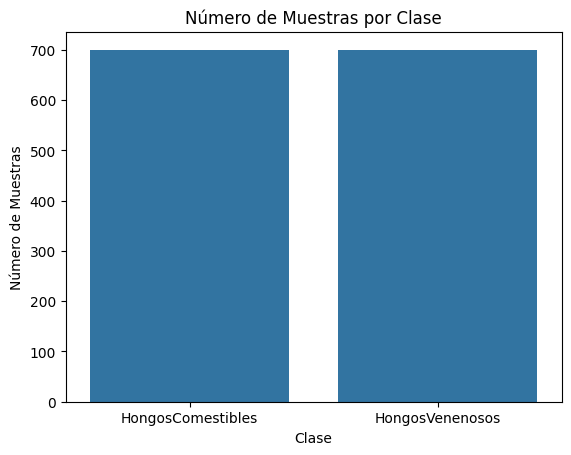

In [5]:
# Contamos la cantidad de muestras por clase
counter = dict(zip(*np.unique(labels, return_counts=True)))

# Creamos la gráfica de barras
sns.barplot(x=list(counter.keys()), y=list(counter.values()))
plt.title('Número de Muestras por Clase')
plt.xlabel('Clase')
plt.ylabel('Número de Muestras')
plt.show()

En esta sección, los datos se dividen en tres conjuntos distintos: datos de entrenamiento, prueba y validación. Esta partición se realiza con el propósito de introducir variabilidad entre los conjuntos y evitar posibles sesgos en los resultados. 

In [6]:

# Primero, divide los datos en entrenamiento y el resto
images_train, images_temp, labels_train, labels_temp = train_test_split(images, labels, test_size=0.3, random_state=42)

# Luego, divide el resto en conjuntos de prueba y validación
images_test, images_validation, labels_test, labels_validation = train_test_split(images_temp, labels_temp, test_size=0.33, random_state=42)
# Normalizamos los valores de los pixeles entre 0 y 1.
images_train, images_test, images_validation = images_train / 255.0, images_test / 255.0, images_validation / 255.0

Con el fin de verificar la correcta transmisión de las imágenes, se procede a exhibir 25 imágenes de hongos, abarcando tanto ejemplos de hongos comestibles como venenosos. Esta revisión visual tiene como objetivo confirmar la integridad del proceso, observando la presentación adecuada de las imágenes en color y su clasificación correcta, asegurando que todo sali&oacute; bien.

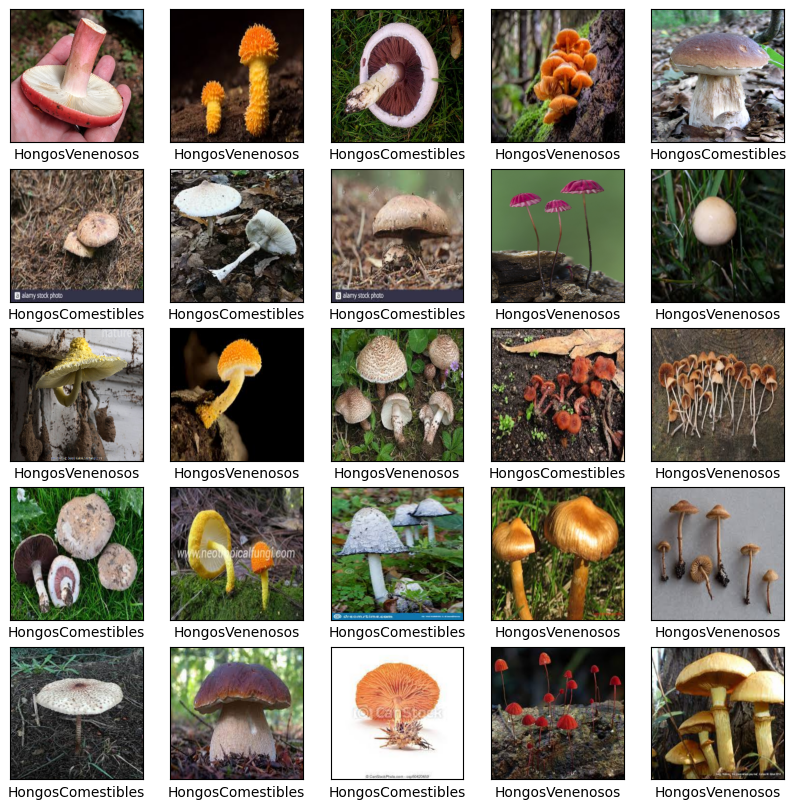

In [7]:
# Creamos una variable para que sea aleatoria entre los valores de las imágenes para poder representar 25 de ellas al azar
indexs = np.random.randint(0, len(images_train), 25)

class_names = ['HongosComestibles', 'HongosVenenosos']

plt.figure(figsize=(10,10))
for i, j in enumerate(indexs):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Convertir de BGR a RGB para visualización
    image_rgb = cv2.cvtColor(images_train[j], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.xlabel((labels_train[j]))  # Se muestra el índice correspondiente a la etiqueta
plt.show()

Como un método adicional para apreciar la diversidad de las imágenes, se llevará a cabo una visualización tridimensional (3D) de las dimensiones de las imágenes. Esta representación permitirá observar la disposición y agrupación de las imágenes en un espacio tridimensional.

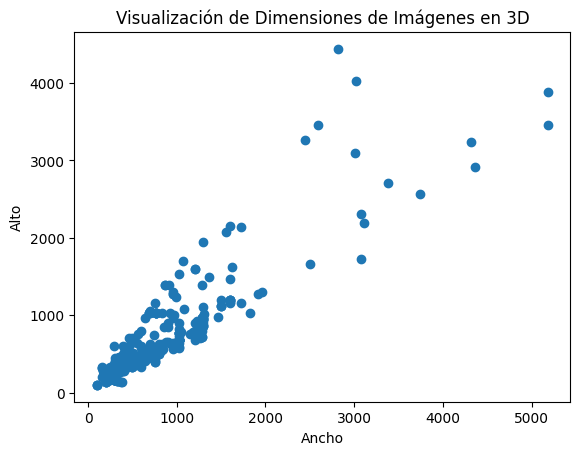

In [8]:
data_test = os.getcwd() + "/Dataset_Hongos"
dimensions = []
for folder_path in os.listdir(data_test):
    ruta = os.path.join(data_test, folder_path)
    for file in os.listdir(ruta):
        img = cv2.imread(os.path.join(ruta, file))
        if img is not None:
            height, width, _ = img.shape
            dimensions.append((width, height))
# Convierte las dimensiones a un formato numpy para facilitar la visualización
dimensions = np.array(dimensions)

# Asegúrate de que dimensions sea bidimensional
dimensions = dimensions.reshape(-1, 2)

# Visualiza las dimensiones en 3D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dimensions[:, 0], dimensions[:, 1])
ax.set_title('Visualización de Dimensiones de Imágenes en 3D')
ax.set_xlabel('Ancho')
ax.set_ylabel('Alto')
plt.show()

## Aumento de Datos

Con el propósito de establecer una comparación con los resultados obtenidos mediante la red neuronal que se implementará a continuación, se llevará a cabo un proceso de aumento del número de imágenes. Este enfoque busca evaluar si existe una diferencia significativa en los resultados al incrementar la cantidad de imágenes disponibles para el entrenamiento del modelo, proporcionando así una perspectiva sobre la sensibilidad del modelo a la variación en el conjunto de datos.

Con el objetivo de llevar a cabo la expansión del conjunto de datos, se implementarán diversas técnicas. En primer lugar, se establece que las imágenes tendrán un tamaño de 256 x 256 píxeles. Además, se aplicarán transformaciones como rotación aleatoria, cambio de escala aleatorio (zoom), cambio de posición aleatorio y volteo horizontal aleatorio a las imágenes. Estas operaciones buscan introducir variabilidad en el conjunto de datos, permitiendo que la red neuronal aprenda a partir de imágenes con similitud a las originales, pero con variaciones que enriquecen la diversidad del conjunto. Al final de esto imprimir&aacute; el n&uacute;mero de im&aacute;genes aumentadas en total, en este caso 2940.

In [10]:
images_augmented = []  # Lista para almacenar las imágenes aumentadas
labels_augmented = []  # Lista para almacenar las etiquetas de las imágenes aumentadas

images_increased = 3

# Supongamos que ya tienes las variables images_train y labels_train del código anterior

width_shape, height_shape = 256, 256

num_augmented_images = 0

for idx, (img, label) in enumerate(zip(images_train, labels_train)):
    # Aplica aumentos de datos utilizando OpenCV
    for t in range(images_increased):
        # Realiza una rotación aleatoria
        angle = np.random.uniform(-20, 20)
        M = cv2.getRotationMatrix2D((width_shape / 2, height_shape / 2), angle, 1.0)
        rotated_img = cv2.warpAffine(img, M, (width_shape, height_shape))
        # Realiza un cambio de escala aleatorio (zoom)
        scale_factor = np.random.uniform(0.8, 1.2)
        scaled_img = cv2.resize(rotated_img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_AREA)
        # Realiza un cambio de posición aleatorio
        dx = np.random.randint(-10, 10)
        dy = np.random.randint(-10, 10)
        translated_img = np.roll(scaled_img, (dx, dy), axis=(0, 1))
        # Voltea horizontalmente aleatoriamente
        if np.random.choice([True, False]):
            flipped_img = cv2.flip(translated_img, 1)
        else:
            flipped_img = translated_img
        # Guarda la imagen aumentada en la lista
        images_augmented.append((flipped_img * 255).astype(np.uint8))
        labels_augmented.append(label)
        num_augmented_images += 1

print("Total augmented images:", num_augmented_images)

Total augmented images: 2940


En este caso, se aplica el mismo preprocesamiento que se efectuó previamente a las imágenes. Se asegura que todas tengan las mismas dimensiones, se transforma la lista de imágenes en un arreglo, se normalizan los valores y se realiza una conversión de los datos a tipo flotante. Este proceso estandariza las imágenes y las prepara adecuadamente para su utilización en el entrenamiento y evaluación de la red neuronal.

In [11]:
# Lista para almacenar las imágenes aumentadas con dimensiones comunes
images_augmented_resized = []

# Asegúrate de que todas las imágenes tengan el mismo tamaño
for img in images_augmented:
    resized_img = cv2.resize(img, (width_shape, height_shape))
    images_augmented_resized.append(resized_img)

# Convierte la lista a un array de NumPy
images_augmented = np.array(images_augmented_resized)

# Normaliza los valores de píxeles al rango [0, 1]
images_augmented = images_augmented / 255.0

# Aplica la conversión de tipo
images_augmented = images_augmented.astype(np.float32)

Para verificar la integridad del proceso, se procede a imprimir 25 imágenes seleccionadas al azar de entre hongos venenosos y comestibles. La observación de estas imágenes revela que presentan variaciones con respecto a las originales, evidenciando efectivamente la aplicación exitosa de las transformaciones, como rotación y aumento de zoom, entre otras.

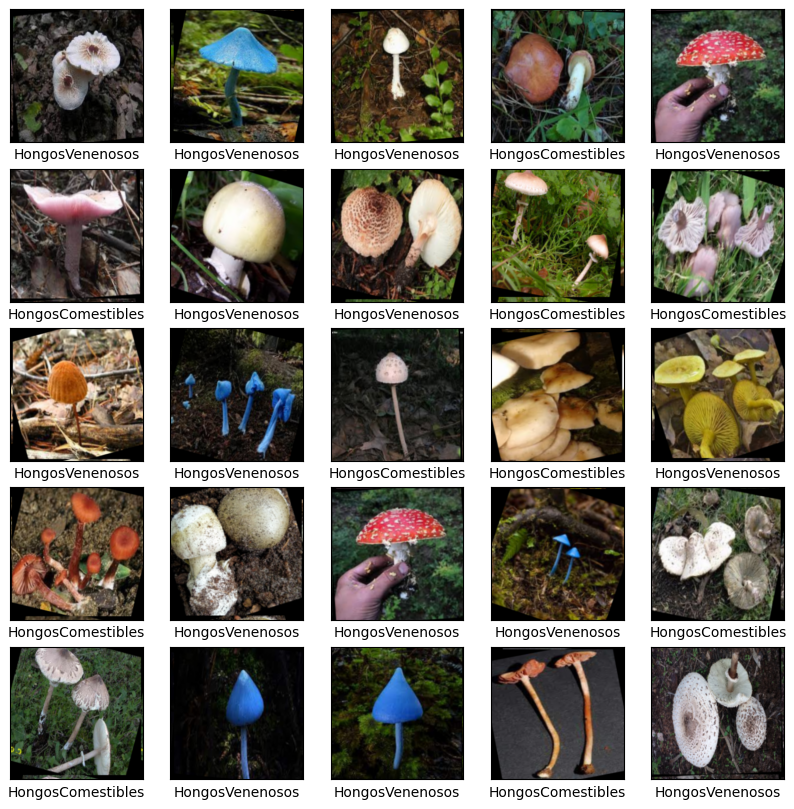

In [12]:
# Creamos una variable para que sea aleatoria entre los valores de las imágenes para poder representar 25 de ellas al azar
indexs = np.random.randint(0, len(images_augmented), 25)

class_names = ['HongosComestibles', 'HongosVenenosos']

plt.figure(figsize=(10,10))
for i, j in enumerate(indexs):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    # Convertir de BGR a RGB para visualización
    image_rgb = cv2.cvtColor(images_augmented[j], cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.xlabel((labels_augmented[j]))  # Se muestra el índice correspondiente a la etiqueta
plt.show()

## Tratamiento del dataset

Para habilitar el uso del conjunto de imágenes en la red neuronal, se requiere procesar los datos y transformarlos de imágenes a valores de etiquetas con una escala de 0 a 1. Con el propósito de verificar la correcta ejecución de este proceso, se procede a imprimir los valores obtenidos.

Primero, llevamos a cabo este proceso para los datos de entrenamiento.

In [13]:
# Se utiliza el label encoder para pasar las imagenes a valores de etiqueta.

encoder = LabelEncoder()

#Inicializar el objeto encoder
labels_tra = encoder.fit_transform(labels_train)

#Mostrar las herramientras numericas correspondientes
print(labels_tra)

[1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0
 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0
 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1
 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0
 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0
 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0
 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0
 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0
 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0
 0 1 0 1 1 1 1 0 1 0 0 1 

De igual forma a la transformación realizada para los datos de entrenamiento, se efectúa el mismo proceso para los datos de prueba. Al finalizar, se imprime el resultado de este procedimiento, permitiendo así la inspección y confirmación de la correcta preparación de los datos de prueba.

In [14]:
labels_tes = encoder.fit_transform(labels_test)

#Mostrar las etiquetas numericas correspondientes
print(labels_tes)

[1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1
 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1
 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0
 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0
 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1
 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1]


Igualmente, se replica el proceso para los datos de validación.

In [15]:
labels_vali = encoder.fit_transform(labels_validation)
print(labels_vali)

[1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1
 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 1]


Finalmente, se realiza el mismo procedimiento para los datos aumentados.

In [16]:
labels_aug = encoder.fit_transform(labels_augmented)
print(labels_aug)

[1 1 1 ... 1 1 1]


Antes de iniciar el diseño del modelo, es crucial verificar la integridad de las dimensiones de la matriz de datos, asegurándose de que estén correctamente configuradas. De igual manera, se debe realizar una comprobación de las etiquetas asociadas a las imágenes para garantizar la consistencia y precisión de los datos que serán utilizados en la construcción del modelo.

In [17]:
print(images_train.shape)
print(labels_tra.shape)
print(images_test.shape)
print(labels_tes.shape)

(980, 256, 256, 3)
(980,)
(281, 256, 256, 3)
(281,)


## Convolutional Neural Network (CNN)

In [18]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
Total params: 111680 (436.25 KB)
Trainable params: 11168

Agregar capas densas en la capa superior

In [21]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 flatten (Flatten)           (None, 230400)            0

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [24]:
history = model.fit(images_train, labels_tra, epochs=10, 
                    validation_data=(images_test, labels_tes))

Epoch 1/10



c:\Users\spoon\Documents\GitHub\ClasificadorHongos\env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



31/31 [==============================] - 20s 605ms/step - loss: 0.9408 - accuracy: 0.4908 - val_loss: 0.6710 - val_accuracy: 0.5409
Epoch 2/10
31/31 [==============================] - 17s 551ms/step - loss: 0.6867 - accuracy: 0.5653 - val_loss: 0.6841 - val_accuracy: 0.5765
Epoch 3/10
31/31 [==============================] - 16s 509ms/step - loss: 0.6637 - accuracy: 0.6051 - val_loss: 0.7007 - val_accuracy: 0.4982
Epoch 4/10
31/31 [==============================] - 16s 509ms/step - loss: 0.6289 - accuracy: 0.6429 - val_loss: 0.6822 - val_accuracy: 0.6192
Epoch 5/10
31/31 [==============================] - 16s 507ms/step - loss: 0.5328 - accuracy: 0.7082 - val_loss: 0.7629 - val_accuracy: 0.5302
Epoch 6/10
31/31 [==============================] - 16s 512ms/step - loss: 0.3991 - accuracy: 0.8276 - val_loss: 0.8190 - val_accuracy: 0.5658
Epoch 7/10
31/31 [==============================] - 16s 510ms/step - loss: 0.2034 - accuracy: 0.9224 - val_loss: 1.2648 - val_accuracy: 0.5730
Epoch 8/1

Evaluamos el modelo

9/9 - 1s - loss: 1.7597 - accuracy: 0.5765 - 1s/epoch - 141ms/step


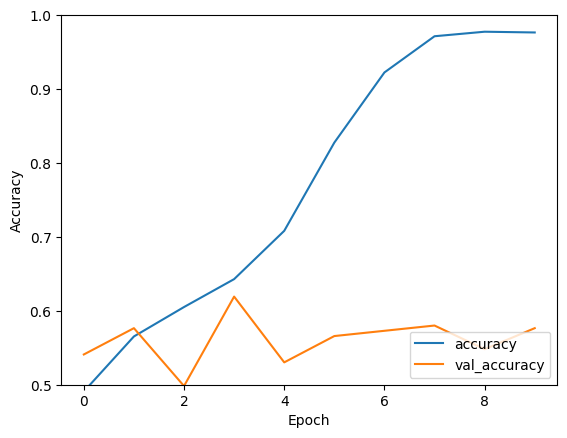

In [25]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(images_test,  labels_tes, verbose=2)

In [26]:
print(test_acc)

0.5765124559402466


5/5 [==============================] - 1s 117ms/step


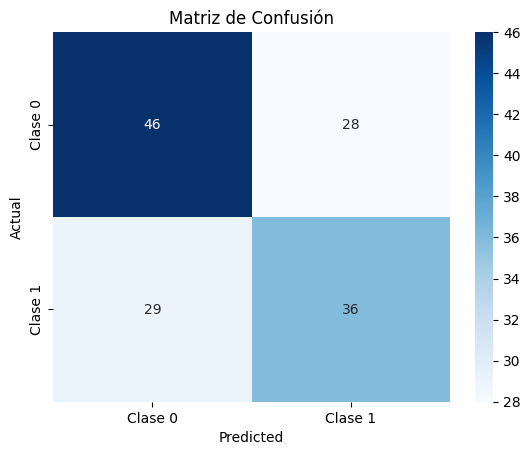

In [27]:
y_pred_prob = model.predict(images_validation)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(labels_vali, y_pred)

# Visualizar la matriz de confusión utilizando seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

## CNN con Datos aumentados

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 128)     36992     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
Total params: 111680 (436.25 KB)
Trainable params: 111

Agregar capas densas en la capa superior

In [30]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [31]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 128)     36992     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 flatten_1 (Flatten)         (None, 230400)           

In [32]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])



In [33]:
print(labels_tra.shape)
print(labels_aug.shape)
labels_tra = labels_tra.reshape((-1, 1))
labels_aug = labels_aug.reshape((-1, 1))
print(labels_tra.shape)
print(labels_aug.shape)

(980,)
(2940,)
(980, 1)
(2940, 1)


In [34]:
print(images_train.shape)
print(images_augmented.shape)

(980, 256, 256, 3)
(2940, 256, 256, 3)


In [35]:
new_train = np.concatenate((images_train, images_augmented))
new_labels = np.concatenate((labels_tra, labels_aug))

In [36]:
new_labels = new_labels.reshape(-1)
print(new_train.shape)
print(new_labels.shape)

(3920, 256, 256, 3)
(3920,)


In [37]:
history = model.fit(new_train, new_labels, epochs=10, 
                    validation_data=(images_test, labels_tes))

Epoch 1/10


c:\Users\spoon\Documents\GitHub\ClasificadorHongos\env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


123/123 [==============================] - 68s 531ms/step - loss: 0.7284 - accuracy: 0.5482 - val_loss: 0.6973 - val_accuracy: 0.4769
Epoch 2/10
123/123 [==============================] - 62s 500ms/step - loss: 0.6593 - accuracy: 0.6000 - val_loss: 0.6847 - val_accuracy: 0.5943
Epoch 3/10
123/123 [==============================] - 61s 497ms/step - loss: 0.6104 - accuracy: 0.6663 - val_loss: 0.6635 - val_accuracy: 0.5730
Epoch 4/10
123/123 [==============================] - 61s 497ms/step - loss: 0.5323 - accuracy: 0.7301 - val_loss: 0.7096 - val_accuracy: 0.6014
Epoch 5/10
123/123 [==============================] - 61s 495ms/step - loss: 0.4288 - accuracy: 0.7906 - val_loss: 0.8421 - val_accuracy: 0.5979
Epoch 6/10
123/123 [==============================] - 61s 494ms/step - loss: 0.2600 - accuracy: 0.8839 - val_loss: 1.1196 - val_accuracy: 0.5836
Epoch 7/10
123/123 [==============================] - 61s 499ms/step - loss: 0.1254 - accuracy: 0.9551 - val_loss: 1.8951 - val_accuracy: 0.5

Evaluamos el modelo

9/9 - 1s - loss: 2.7654 - accuracy: 0.5623 - 1s/epoch - 141ms/step


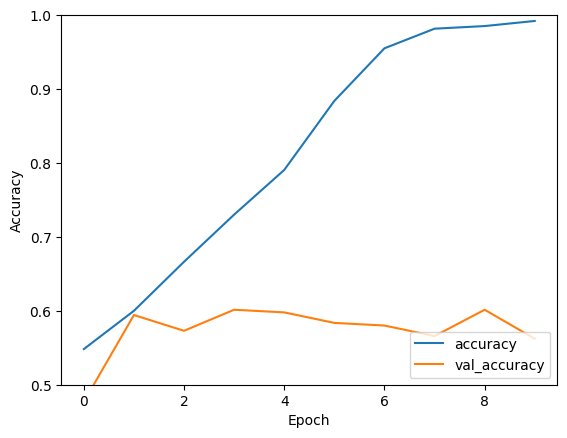

In [38]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(images_test,  labels_tes, verbose=2)

In [39]:
print(test_acc)

0.5622775554656982


5/5 [==============================] - 1s 117ms/step


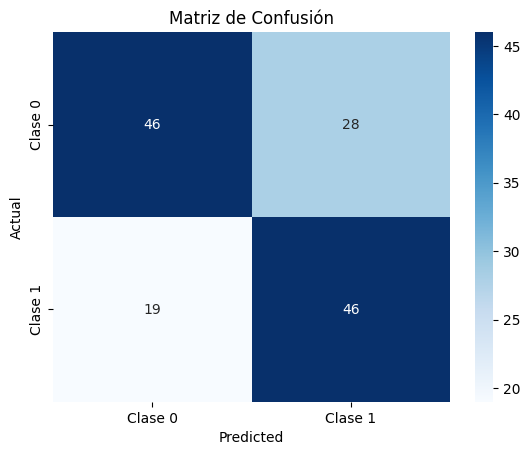

In [40]:
y_pred_prob = model.predict(images_validation)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(labels_vali, y_pred)

# Visualizar la matriz de confusión utilizando seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

## Machine Learning Tradicional

In [41]:
encoder = LabelEncoder()

#Inicializar el objeto encoder
labels_entero = encoder.fit_transform(labels)

#Mostrar las herramientras numericas correspondientes
print(labels_entero)

[0 0 0 ... 1 1 1]


In [42]:
# Aplana las imágenes
images_flattened = images.reshape(images.shape[0], -1)

# Usar StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

clf_rf = RandomForestClassifier(n_estimators=10, random_state=0)
scores = []

for train_index, test_index in sss.split(images_flattened, labels_entero):
    X_train, X_test = images_flattened[train_index], images_flattened[test_index]
    y_train, y_test = labels_entero[train_index], labels_entero[test_index]
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(np.mean(scores))


[0.5609977324263039, 0.5488330994334425, 0.5857283142389526, 0.5941456406572686, 0.5785499260166335]
0.5736509425545202


## Algoritmos de metaaprendizaje

In [ ]:
# Aplana las imágenes
images_flattened = images.reshape(images.shape[0], -1)

# Usar StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

clf_rf = GaussianNB()
scores = []

for train_index, test_index in sss.split(images_flattened, labels_entero):
    X_train, X_test = images_flattened[train_index], images_flattened[test_index]
    y_train, y_test = labels_entero[train_index], labels_entero[test_index]
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(np.mean(scores))

[0.5409600901685536, 0.6047025001283434, 0.5392290249433106, 0.5949354124259068, 0.5642249429342188]
0.5688103941200666


In [ ]:
y_pred_prob = model.predict(images_validation)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(labels_vali, y_pred)

# Visualizar la matriz de confusión utilizando seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Aplana las imágenes
images_flattened = images.reshape(images.shape[0], -1)

# Usar StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

clf_rf = AdaBoostClassifier(n_estimators=10, random_state=0)
scores = []

for train_index, test_index in sss.split(images_flattened, labels_entero):
    X_train, X_test = images_flattened[train_index], images_flattened[test_index]
    y_train, y_test = labels_entero[train_index], labels_entero[test_index]
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(np.mean(scores))

[0.5706399509302801, 0.5737767828589703, 0.597948717948718, 0.5857142857142857, 0.5678516307605964]
0.5791862736425701


In [ ]:
# Aplana las imágenes
images_flattened = images.reshape(images.shape[0], -1)

# Usar StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

clf_rf = GradientBoostingClassifier(n_estimators=10)
scores = []

for train_index, test_index in sss.split(images_flattened, labels_entero):
    X_train, X_test = images_flattened[train_index], images_flattened[test_index]
    y_train, y_test = labels_entero[train_index], labels_entero[test_index]
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(np.mean(scores))

[0.5918367346938775, 0.5710784313725489, 0.613970588235294, 0.6356956987601409, 0.5565772669220945]
0.5938317439967912


In [ ]:
# Aplana las imágenes
images_flattened = images.reshape(images.shape[0], -1)

# Usar StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

clf_rf = BaggingClassifier(n_estimators=10)
scores = []

for train_index, test_index in sss.split(images_flattened, labels_entero):
    X_train, X_test = images_flattened[train_index], images_flattened[test_index]
    y_train, y_test = labels_entero[train_index], labels_entero[test_index]
    clf_rf.fit(X_train, y_train)
    y_pred = clf_rf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='weighted'))

print(scores)
print(np.mean(scores))

## CNN CON CAMBIOS

In [43]:
# Definimos la ruta a la carpeta que contiene las imágenes que se usarán para prueba
data_test = os.getcwd() + "/Dataset_Hongos"

max_muestras = 700
# Cargamos las imágenes que se usarán para prueba 
images = []
labels = []

for category in os.listdir(data_test):
    category_dir = os.path.join(data_test, category)
    for image_file, i in zip(os.listdir(category_dir), range(max_muestras)):
        image_test = cv2.imread(os.path.join(category_dir, image_file))
        image_test = cv2.resize(image_test, (32, 32))  # Redimensionamos las imágenes a 32x32
        image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)  # Convertir a escala de grises
        images.append(image_test)
        labels.append(category)

# Convertimos las imágenes a un formato compatible con TensorFlow
images = np.array(images)
images = images.astype(np.float32)


In [44]:
# Primero, divide los datos en entrenamiento y el resto
images_train, images_temp, labels_train, labels_temp = train_test_split(images, labels, test_size=0.3, random_state=42)

# Luego, divide el resto en conjuntos de prueba y validación
images_test, images_validation, labels_test, labels_validation = train_test_split(images_temp, labels_temp, test_size=0.33, random_state=42)
# Normalizamos los valores de los pixeles entre 0 y 1.
images_train, images_test, images_validation = images_train / 255.0, images_test / 255.0, images_validation / 255.0

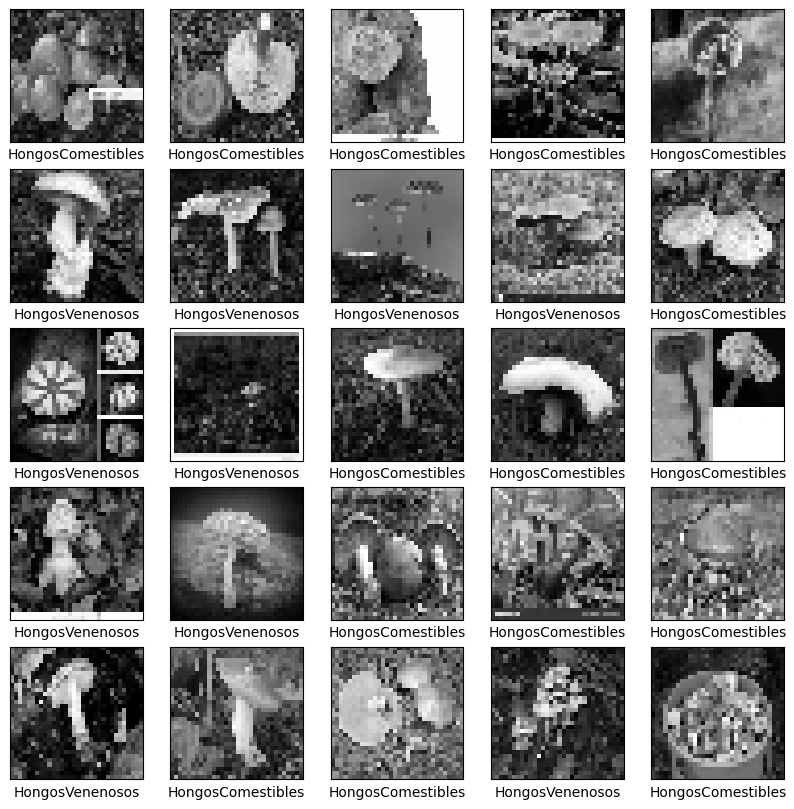

In [45]:
# Creamos una variable para que sea aleatoria entre los valores de las imágenes para poder representar 25 de ellas al azar
indexs = np.random.randint(0, len(images_train), 25)

class_names = ['HongosComestibles', 'HongosVenenosos']

plt.figure(figsize=(10,10))
for i, j in enumerate(indexs):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # Si las imágenes ya están en escala de grises, simplemente muéstralas
    # Sin necesidad de la conversión de color
    plt.imshow(images_train[j], cmap='gray')  # Usar cmap='gray' para mostrar la imagen en escala de grises
    plt.xlabel(labels_train[j])  # Se muestra el índice correspondiente a la etiqueta
plt.show()



In [46]:
# Se utiliza el label encoder para pasar las imagenes a valores de etiqueta.

encoder = LabelEncoder()

#Inicializar el objeto encoder
labels_train_grises = encoder.fit_transform(labels_train)

#Mostrar las herramientras numericas correspondientes
print(labels_train_grises)

[1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0
 0 0 1 1 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0
 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 0 0
 0 1 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 0 0 0 0 0 1 1 1
 0 1 1 1 1 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 1 1 0 1 0 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0
 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 0
 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0
 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 1 0
 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0
 0 0 0 0 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0
 0 1 0 1 1 1 1 0 1 0 0 1 

In [47]:
labels_test_grises = encoder.fit_transform(labels_test)

#Mostrar las etiquetas numericas correspondientes
print(labels_test_grises)

[1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 1 1
 1 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1
 1 0 0 1 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 0 1
 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 1 0
 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0
 0 1 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 0 0 0
 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 1
 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1]


In [48]:
labels_validation_grises = encoder.fit_transform(labels_validation)
print(labels_validation_grises)

[1 0 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 1
 0 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0
 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 1]


In [49]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) #128
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [50]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 5574

In [51]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten_2 (Flatten)         (None, 1024)             

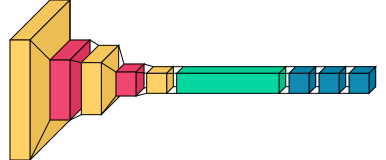

In [53]:
visualkeras.layered_view(model)

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
history = model.fit(images_train, labels_train_grises, epochs=10, 
                    validation_data=(images_test, labels_test_grises))

Epoch 1/10


c:\Users\spoon\Documents\GitHub\ClasificadorHongos\env\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


31/31 [==============================] - 1s 11ms/step - loss: 0.6934 - accuracy: 0.5041 - val_loss: 0.6919 - val_accuracy: 0.4840
Epoch 2/10
31/31 [==============================] - 0s 6ms/step - loss: 0.6851 - accuracy: 0.5378 - val_loss: 0.6660 - val_accuracy: 0.6228
Epoch 3/10
31/31 [==============================] - 0s 6ms/step - loss: 0.6809 - accuracy: 0.5918 - val_loss: 0.6909 - val_accuracy: 0.5552
Epoch 4/10
31/31 [==============================] - 0s 6ms/step - loss: 0.6656 - accuracy: 0.6092 - val_loss: 0.6886 - val_accuracy: 0.5552
Epoch 5/10
31/31 [==============================] - 0s 6ms/step - loss: 0.6578 - accuracy: 0.6092 - val_loss: 0.6504 - val_accuracy: 0.6121
Epoch 6/10
31/31 [==============================] - 0s 6ms/step - loss: 0.6616 - accuracy: 0.5888 - val_loss: 0.6584 - val_accuracy: 0.5872
Epoch 7/10
31/31 [==============================] - 0s 7ms/step - loss: 0.6458 - accuracy: 0.6296 - val_loss: 0.6689 - val_accuracy: 0.5872
Epoch 8/10
31/31 [============

9/9 - 0s - loss: 0.6556 - accuracy: 0.5836 - 37ms/epoch - 4ms/step


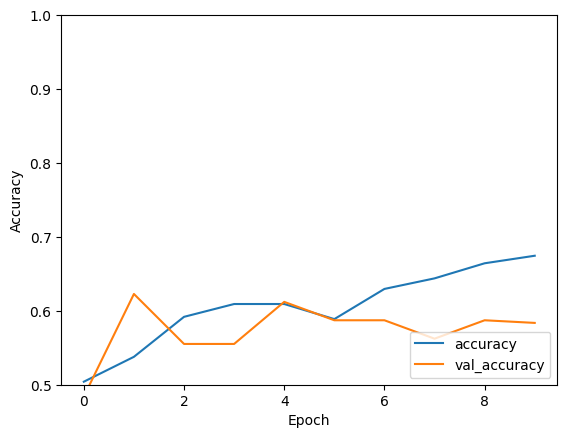

In [56]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(images_test,  labels_test_grises, verbose=2)

In [57]:
print(test_acc)

0.5836299061775208


5/5 [==============================] - 0s 2ms/step


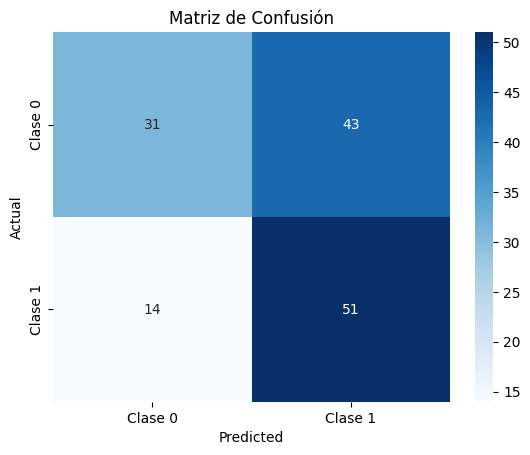

In [58]:
y_pred_prob = model.predict(images_validation)
y_pred = np.argmax(y_pred_prob, axis=1)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(labels_validation_grises, y_pred)

# Visualizar la matriz de confusión utilizando seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

## Conclusiones

Mis datos son demasiado variados, por lo cual no esta haciendo el entrenamiento adecuado, creo que si las imagenes fueran mas uniformes los resultados serian mucho mejores y la CNN aprenderia, en cambio como son demasiado variados no esta aprendiendo, tal vez este tomando el fondo en lugar del hongo y por eso entrena mal los datos.